# Pruebas de la API FastAPI

Este notebook prueba los diferentes endpoints de la API de predicción.

In [1]:
# Celda 1: Configuración e importaciones
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt

BASE_URL = "http://localhost:8000"

print("🚀 Configurando pruebas de la API...")

🚀 Configurando pruebas de la API...


In [3]:
# Celda 2: Probar health check
def test_health():
    response = requests.get(f"{BASE_URL}/health")
    if response.status_code == 200:
        print("✅ Health check exitoso")
        print(json.dumps(response.json(), indent=2))
        return True
    else:
        print("❌ Health check falló")
        return False

test_health()

✅ Health check exitoso
{
  "status": "healthy",
  "timestamp": "2025-09-25T15:28:23.437572",
  "model_version": "1.0.0",
  "model_loaded": true
}


True

In [5]:
#  Celda 3: Probar predicción individual
def test_prediction():
    data = {
        "edad": 45,
        "tipo_vehiculo": "SUV",
        "antiguedad_vehiculo": 5,
        "region": "Norte",
        "historial_siniestros": 2
    }
    
    response = requests.post(f"{BASE_URL}/predict", json=data)
    
    if response.status_code == 200:
        result = response.json()
        print("✅ Predicción individual exitosa")
        print(f"📋 Resultado:")
        print(f"   - ID: {result['prediction_id']}")
        print(f"   - Costo predicho: ${result['prediction']:,.2f}")
        print(f"   - Intervalo: ${result['confidence_interval']['lower_bound']:,.2f} - ${result['confidence_interval']['upper_bound']:,.2f}")
        return result
    else:
        print(f"❌ Error: {response.status_code} - {response.text}")
        return None

result = test_prediction()

✅ Predicción individual exitosa
📋 Resultado:
   - ID: pred_20250925_153126
   - Costo predicho: $1,590.89
   - Intervalo: $1,352.25 - $1,829.52


📊 Comparación de perfiles de riesgo:
            perfil    costo  edad tipo_vehiculo  historial
0      Bajo riesgo  1434.68    40         Sedan          0
1     Medio riesgo  1590.89    45           SUV          2
2      Alto riesgo  1561.99    22   Motocicleta          4
3  Muy alto riesgo  1440.71    68        Pickup          6


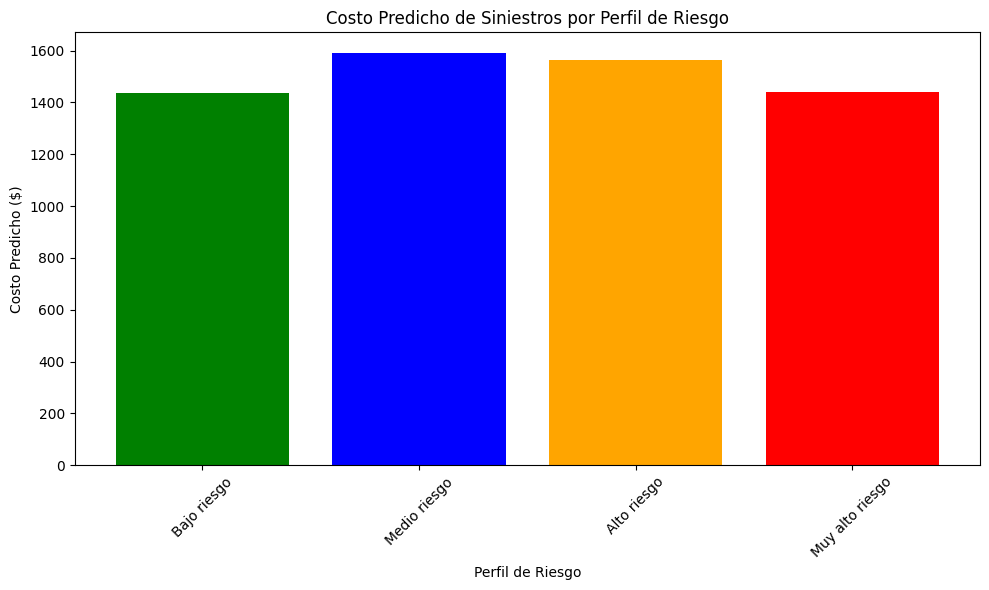

In [6]:
# Celda 4: Probar diferentes perfiles de riesgo
def test_risk_profiles():
    profiles = [
        {"nombre": "Bajo riesgo", "datos": {"edad": 40, "tipo_vehiculo": "Sedan", "antiguedad_vehiculo": 3, "region": "Sur", "historial_siniestros": 0}},
        {"nombre": "Medio riesgo", "datos": {"edad": 45, "tipo_vehiculo": "SUV", "antiguedad_vehiculo": 5, "region": "Norte", "historial_siniestros": 2}},
        {"nombre": "Alto riesgo", "datos": {"edad": 22, "tipo_vehiculo": "Motocicleta", "antiguedad_vehiculo": 1, "region": "Este", "historial_siniestros": 4}},
        {"nombre": "Muy alto riesgo", "datos": {"edad": 68, "tipo_vehiculo": "Pickup", "antiguedad_vehiculo": 18, "region": "Oeste", "historial_siniestros": 6}}
    ]
    
    results = []
    for profile in profiles:
        response = requests.post(f"{BASE_URL}/predict", json=profile["datos"])
        if response.status_code == 200:
            pred = response.json()
            results.append({
                "perfil": profile["nombre"],
                "costo": pred["prediction"],
                "edad": profile["datos"]["edad"],
                "tipo_vehiculo": profile["datos"]["tipo_vehiculo"],
                "historial": profile["datos"]["historial_siniestros"]
            })
    
    # Crear DataFrame y visualizar
    df_results = pd.DataFrame(results)
    print("📊 Comparación de perfiles de riesgo:")
    print(df_results)
    
    # Gráfico de comparación
    plt.figure(figsize=(10, 6))
    plt.bar(df_results["perfil"], df_results["costo"], color=['green', 'blue', 'orange', 'red'])
    plt.title("Costo Predicho de Siniestros por Perfil de Riesgo")
    plt.ylabel("Costo Predicho ($)")
    plt.xlabel("Perfil de Riesgo")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return df_results

risk_results = test_risk_profiles()

In [7]:
# Celda 5: Probar predicción por lote
def test_batch_predict():
    batch_data = [
        {"edad": 30, "tipo_vehiculo": "Sedan", "antiguedad_vehiculo": 2, "region": "Sur", "historial_siniestros": 1},
        {"edad": 50, "tipo_vehiculo": "SUV", "antiguedad_vehiculo": 8, "region": "Norte", "historial_siniestros": 0},
        {"edad": 25, "tipo_vehiculo": "Motocicleta", "antiguedad_vehiculo": 1, "region": "Este", "historial_siniestros": 3}
    ]
    
    response = requests.post(f"{BASE_URL}/batch_predict", json=batch_data)
    
    if response.status_code == 200:
        results = response.json()
        print("✅ Predicción por lote exitosa")
        print(f"📦 Total de predicciones: {results['total_predictions']}")
        
        df_batch = pd.DataFrame(results['results'])
        print(df_batch)
        
        return results
    else:
        print(f"❌ Error: {response.text}")
        return None

batch_results = test_batch_predict()

✅ Predicción por lote exitosa
📦 Total de predicciones: 3
   id  prediction  log_prediction  \
0   1     1587.21          7.3704   
1   2     1564.79          7.3561   
2   3     1555.94          7.3505   

                                            features  
0  {'edad': 30, 'tipo_vehiculo': 'Sedan', 'antigu...  
1  {'edad': 50, 'tipo_vehiculo': 'SUV', 'antigued...  
2  {'edad': 25, 'tipo_vehiculo': 'Motocicleta', '...  


In [8]:
# Celda 6: Probar información del modelo
def test_model_info():
    response = requests.get(f"{BASE_URL}/model_info")
    
    if response.status_code == 200:
        info = response.json()
        print("✅ Información del modelo obtenida")
        print(f"🧠 Modelo: {info['model_name']}")
        print(f"📈 Métricas en prueba:")
        for metric, value in info['test_metrics'].items():
            print(f"   - {metric}: {value:.4f}")
        return info
    else:
        print(f"❌ Error: {response.text}")
        return None

model_info = test_model_info()

✅ Información del modelo obtenida
🧠 Modelo: Linear Regression
📈 Métricas en prueba:
   - MAE: 0.6168
   - RMSE: 0.7991
   - R2: -0.0238
   - MAPE: 8.8654


In [9]:
# Celda 7: Probar documentación automática
print("📚 La documentación automática está disponible en:")
print(f"   - Swagger UI: {BASE_URL}/docs")
print(f"   - ReDoc: {BASE_URL}/redoc")
print("\n🌐 Abre los enlaces en tu navegador para explorar la API interactivamente")

📚 La documentación automática está disponible en:
   - Swagger UI: http://localhost:8000/docs
   - ReDoc: http://localhost:8000/redoc

🌐 Abre los enlaces en tu navegador para explorar la API interactivamente
